In [23]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import zipfile
import os

# กำหนด path ไปยังโฟลเดอร์ใน Drive
drive_folder = '/content/drive/MyDrive/dataset_aibuilders'

# รายชื่อไฟล์ zip ที่จะโหลด
zip_files = ['Salmon.zip', 'Trout.zip']

# โฟลเดอร์ปลายทาง
extract_folder = '/content/dataset'

# สร้างโฟลเดอร์ปลายทางถ้ายังไม่ได้สร้าง
os.makedirs(extract_folder, exist_ok=True)

# โหลดแล้วแตกไฟล์ zip ทีละอัน
for zip_name in zip_files:
    zip_path = os.path.join(drive_folder, zip_name)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(f'แตกไฟล์ {zip_name} เสร็จแล้วอยู่ที่ {extract_folder}')

แตกไฟล์ Salmon.zip เสร็จแล้วอยู่ที่ /content/dataset
แตกไฟล์ Trout.zip เสร็จแล้วอยู่ที่ /content/dataset


In [26]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import pathlib
import random
import shutil


Train: 1444, Valid: 181, Test: 181


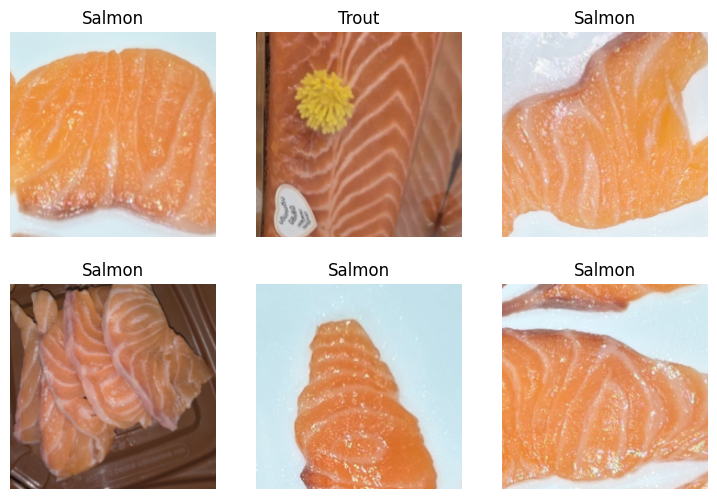

In [27]:
# path ไปยัง raw dataset
raw_data_path = Path('/content/dataset')
all_images = get_image_files(raw_data_path)

# แบ่ง 80% train, 10% valid, 10% test
train_imgs, test_valid_imgs = train_test_split(all_images, test_size=0.2, stratify=[p.parent.name for p in all_images])
valid_imgs, test_imgs = train_test_split(test_valid_imgs, test_size=0.5, stratify=[p.parent.name for p in test_valid_imgs])

# ตรวจสอบ
print(f"Train: {len(train_imgs)}, Valid: {len(valid_imgs)}, Test: {len(test_imgs)}")

# DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # รูปและหมวดหมู่
    get_items=get_image_files,  # ใช้ฟังก์ชันนี้ในการดึงไฟล์
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # ใช้ RandomSplitter แทน
    get_y=parent_label,  # label เป็นชื่อโฟลเดอร์ของแต่ละภาพ
    item_tfms=Resize(224),  # เปลี่ยนขนาดรูป
    batch_tfms=aug_transforms(
        do_flip=True, flip_vert=True,
        max_rotate=20., max_zoom=1.1,
        max_lighting=0.2, max_warp=0.2
    )  # augmentation
)

# สร้าง DataLoaders
dls = dblock.dataloaders(raw_data_path, bs=32)

# ดูข้อมูลตัวอย่างใน DataLoader
dls.show_batch(max_n=6)


In [28]:
save_path = Path('/content/drive/MyDrive/split_dataset')  # เปลี่ยนชื่อโฟลเดอร์ได้
save_path.mkdir(parents=True, exist_ok=True)

# ฟังก์ชันย้ายรูปภาพไปตาม split
def copy_split_images(imgs, split_name):
    split_path = save_path / split_name
    split_path.mkdir(parents=True, exist_ok=True)
    for img in imgs:
        label = img.parent.name  # โฟลเดอร์ชื่อ label
        label_path = split_path / label
        label_path.mkdir(parents=True, exist_ok=True)
        shutil.copy(img, label_path / img.name)

copy_split_images(train_imgs, 'train')
copy_split_images(valid_imgs, 'valid')
copy_split_images(test_imgs, 'test')

In [29]:
# ใช้ resnet34
learn = vision_learner(dls, resnet34, metrics=accuracy)

# เทรนรอบแรก 5 epochs
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.600342,0.144341,0.941828,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.320822,0.102827,0.961219,00:30
1,0.252784,0.127083,0.955679,00:28
2,0.176127,0.081118,0.972299,00:27
3,0.123566,0.068327,0.977839,00:27
4,0.091665,0.068463,0.975069,00:27


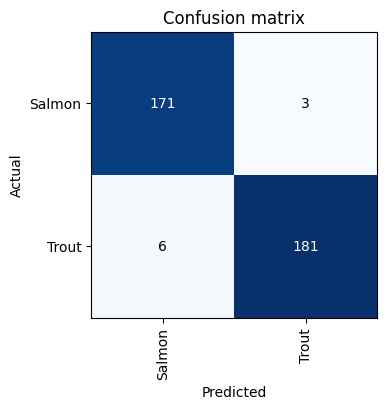

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ดู confusion matrix บน validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))


Predictions: torch.Size([181, 2]), Targets: torch.Size([181])
Test Accuracy: 1.0000


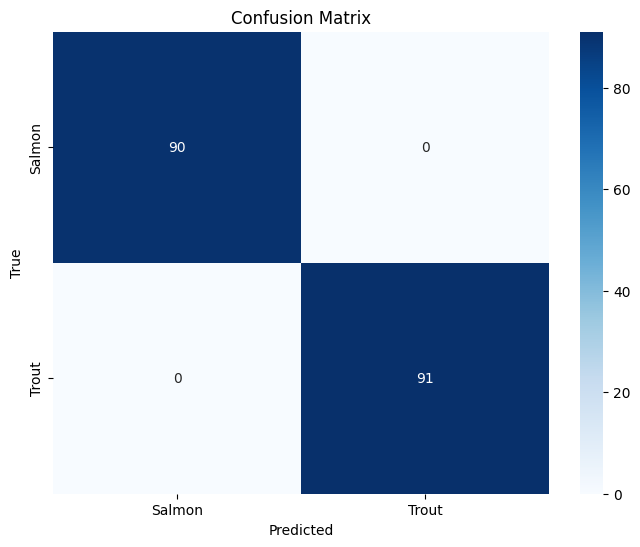


Classification Report:
              precision    recall  f1-score   support

      Salmon       1.00      1.00      1.00        90
       Trout       1.00      1.00      1.00        91

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



In [31]:
# สร้าง test dataloader ขึ้นมา
test_dl = learn.dls.test_dl(test_imgs, with_labels=True)

# เอาผลลัพธ์จาก test set
preds, targs = learn.get_preds(dl=test_dl)

# ตรวจสอบผลลัพธ์
if preds is None or targs is None:
    print("Error: preds or targs is None")
else:
    # พิมพ์ค่า preds และ targs เพื่อตรวจสอบ
    print(f"Predictions: {preds.shape}, Targets: {targs.shape}")

    # คำนวณ accuracy
    acc = (preds.argmax(dim=1) == targs).float().mean()
    print(f"Test Accuracy: {acc:.4f}")

    # สร้าง confusion matrix
    cm = confusion_matrix(targs, preds.argmax(dim=1))

    # แสดง confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=learn.dls.vocab, yticklabels=learn.dls.vocab)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # แสดง classification report (Precision, Recall, F1 Score)
    print("\nClassification Report:")
    print(classification_report(targs, preds.argmax(dim=1), target_names=learn.dls.vocab))


In [43]:
from google.colab import files
from PIL import Image

# Step 1: อัปโหลดรูปจากเครื่อง
uploaded = files.upload()  # จะมีช่องให้อัปโหลดไฟล์

# Step 2: โหลดรูปภาพเข้า fastai
for fname in uploaded.keys():
    img = PILImage.create(fname)

    # Step 3: ใช้โมเดลที่ฝึกไว้ทำนาย
    pred, pred_idx, probs = learn.predict(img)

    # Step 4: แสดงผลลัพธ์
    print(f"\nรูปภาพ: {fname}")
    print(f"ผลการทำนาย: {pred}")
    print(f"ความมั่นใจแต่ละคลาส: {probs}")

Saving Screenshot 2025-05-08 121815.png to Screenshot 2025-05-08 121815.png



รูปภาพ: Screenshot 2025-05-08 121815.png
ผลการทำนาย: Salmon
ความมั่นใจแต่ละคลาส: tensor([0.9875, 0.0125])
